### Data Cleaning 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
import seaborn as sns
from mlxtend.frequent_patterns import apriori, association_rules
import re

/Users/xiongsimeng/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
df = pd.read_excel ("Trends_2013_2023_de-identified.xls")
df.head()

df.rename(columns={
    "ID":"id",
    "Date & Time": "date_time",
    "Location": "location",  
    "Accession.":"accession",
    "Indications":"indications",
    "A F I  Sum":"afi_sum",
    "B P D":"bpd",
    "H C":"hc",
    "A C":"ac",
    "F L":"fl",
    "H U M":"hum",
    "BPD %tile":"bpd_ptile",
    "HC %tile":"hc_ptile",
    "AC %tile":"ac_ptile",
    "FL %tile":"fl_ptile",
    "HUM %tile":"hum_ptile",
    "EDD":"edd",
    "F  Weight":"f_weight",
    "% tile":"ptile",
    "Best":"best",
}, inplace=True)

## Convert time to time format 
df["date_time"] = pd.to_datetime(df["date_time"])

df["edd"] = pd.to_datetime(df["edd"], errors="coerce") 
#“If a value can’t be parsed as a date, don’t crash or leave it as a string—instead convert it to NaT (Not a Time).”

df["indications"] = (
  df["indications"] # take the raw text
      .fillna("") # guard against nulls
      .str.strip() # remove leading/trailing whitespace
      .str.lower() # convert everything to lowercase
      .str.replace(r"\s+", " ", regex=True) 
)

print(df.shape)

## Number of ultrasound data 
n_exams = df[["id","date_time"]].drop_duplicates().shape[0]
print("number of ultrasound data by time:",n_exams)

## Number of patients
n_patients = df["id"].drop_duplicates().shape[0]
print("number of patients by id:",n_patients)


(64979, 20)
number of ultrasound data by time: 19857
number of patients by id: 13741


In [3]:
## Delete the 2013 data 
df = df[df['date_time'].dt.year != 2013]
print(df.shape)

## Number of ultrasound data 
n_exams = df[["id","date_time"]].drop_duplicates().shape[0]
print("number of ultrasound data by time:",n_exams)

## Number of patients
n_patients = df["id"].drop_duplicates().shape[0]
print("number of patients by id:",n_patients)

(64967, 20)
number of ultrasound data by time: 19852
number of patients by id: 13737


In [4]:
print(df["indications"].nunique())

1550


In [5]:
df["afi_sum"] = pd.to_numeric(df["afi_sum"], errors="coerce")
df.info()
df.describe(include="all")

<class 'pandas.core.frame.DataFrame'>
Index: 64967 entries, 0 to 64978
Data columns (total 20 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   id           64967 non-null  object        
 1   date_time    64967 non-null  datetime64[ns]
 2   location     64967 non-null  object        
 3   accession    61368 non-null  object        
 4   indications  64967 non-null  object        
 5   afi_sum      61428 non-null  float64       
 6   bpd          54143 non-null  float64       
 7   hc           54123 non-null  float64       
 8   ac           54127 non-null  float64       
 9   fl           54127 non-null  float64       
 10  hum          38489 non-null  float64       
 11  bpd_ptile    48115 non-null  object        
 12  hc_ptile     48096 non-null  object        
 13  ac_ptile     48084 non-null  object        
 14  fl_ptile     48085 non-null  object        
 15  hum_ptile    34579 non-null  object        
 16  edd      

,id,date_time,location,accession,indications,afi_sum,bpd,hc,ac,fl,hum,bpd_ptile,hc_ptile,ac_ptile,fl_ptile,hum_ptile,edd,f_weight,ptile,best
count,64967,64967,64967,61368,64967,61428.000000,54143.000000,54123.000000,54127.000000,54127.000000,38489.000000,48115,48096,48084,48085,34579,54179,54132.000000,54132,64967
unique,13737,NaN,13,18421,1550,NaN,NaN,NaN,NaN,NaN,NaN,132,135,126,132,93,NaN,NaN,138,43
top,E2608662,NaN,Lattimore,E176276950,"obesity complicating pregnancy, 3rd tri",NaN,NaN,NaN,NaN,NaN,NaN,< 3,< 3,> 97,< 3,< 5,NaN,NaN,> 99,36w 0d
freq,45,NaN,25843,20,6058,NaN,NaN,NaN,NaN,NaN,NaN,5158,10013,9545,7533,4225,NaN,NaN,1776,4353
mean,NaN,2019-11-17 17:08:49.217602560,NaN,NaN,NaN,14.890035,90.311016,327.284222,338.877204,70.762703,62.099690,NaN,NaN,NaN,NaN,NaN,2019-12-11 07:58:58.337732352,3184.225393,NaN,NaN
min,NaN,2014-01-02 08:18:00,NaN,NaN,NaN,0.000000,43.299999,253.899994,214.500000,27.600000,28.000000,NaN,NaN,NaN,NaN,NaN,2013-12-29 00:00:00,1220.000000,NaN,NaN
25%,NaN,2017-06-21 10:46:00,NaN,NaN,NaN,10.620000,87.300003,317.700012,321.799988,68.300003,59.799999,NaN,NaN,NaN,NaN,NaN,2017-07-16 00:00:00,2797.000000,NaN,NaN
50%,NaN,2020-06-18 14:03:00,NaN,NaN,NaN,14.030000,90.300003,327.100006,338.000000,70.800003,62.099998,NaN,NaN,NaN,NaN,NaN,2020-07-09 00:00:00,3143.000000,NaN,NaN
75%,NaN,2022-05-20 13:12:00,NaN,NaN,NaN,18.210000,93.300003,336.600006,355.600006,73.300003,64.400002,NaN,NaN,NaN,NaN,NaN,2022-06-13 00:00:00,3541.000000,NaN,NaN
max,NaN,2023-12-30 08:33:00,NaN,NaN,NaN,53.800000,140.899994,501.700012,445.600006,86.900002,78.599998,NaN,NaN,NaN,NaN,NaN,2024-02-07 00:00:00,5878.000000,NaN,NaN


 n_indications  num_records
             1         4149
             2         4122
             3         3734
             4         3181
             5         2042
             6         1365
             7          606
             8          348
             9          113
            10           91
            11           28
            12           36
            13            3
            14           20
            16            9
            18            4
            20            1


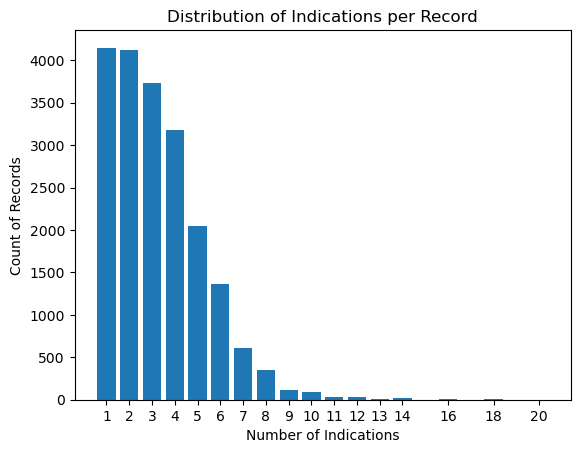

Total scans (records): 19852


In [6]:
## Create new column of count number of indications per patients: 
df["n_indications"] = (
    df
      .groupby(["id","date_time"])["indications"]
      .transform("count")
)


# 1️⃣ Compute the distribution
dist = (
    df
      .groupby(["id","date_time"])      # 1 row per unique scan
      ["n_indications"]
      .first()                          # pick that scan’s n_indications
      .value_counts()                   # count how many scans have each n
      .sort_index()                     # order by 1,2,3,…
)

# Turn it into a nice DataFrame with column names
dist_df = (
    dist
      .rename_axis('n_indications')      # name the index
      .rename('num_records')             # name the counts
      .to_frame()                        # make it a DataFrame
      .reset_index()                     # turn the index into a column
)

# 2️⃣ Show the table
print(dist_df.to_string(index=False))

# 3️⃣ Bar plot
plt.figure()
plt.bar(dist_df['n_indications'], dist_df['num_records'])
plt.xlabel('Number of Indications')
plt.ylabel('Count of Records')
plt.title('Distribution of Indications per Record')
plt.xticks(dist_df['n_indications'])  # ensure every bucket is labeled
plt.show()

## Check 
total_scans = dist.sum()
print("Total scans (records):", total_scans)


## Trimester Analysis 

Ultrasound Indications Counts by Trimester:
 category
1st                      22
2nd                     432
3rd                   13635
no_trimester_label     5763
Name: count, dtype: int64
Distinct Patient Counts by Trimester:
 category
1st                     20
2nd                    385
3rd                   9823
no_trimester_label    4580
Name: id, dtype: int64
category  1st   2nd     3rd  no_trimester_label
year                                           
2014      2.0   2.0     0.0              1557.0
2015      1.0   1.0   203.0               989.0
2016      2.0  36.0   734.0               238.0
2017      1.0  35.0   862.0               249.0
2018      1.0  30.0   875.0               277.0
2019      5.0  41.0  1581.0               318.0
2020      4.0  52.0  1476.0               308.0
2021      0.0  53.0  1723.0               302.0
2022      1.0  70.0  1741.0               266.0
2023      3.0  68.0  1678.0               260.0


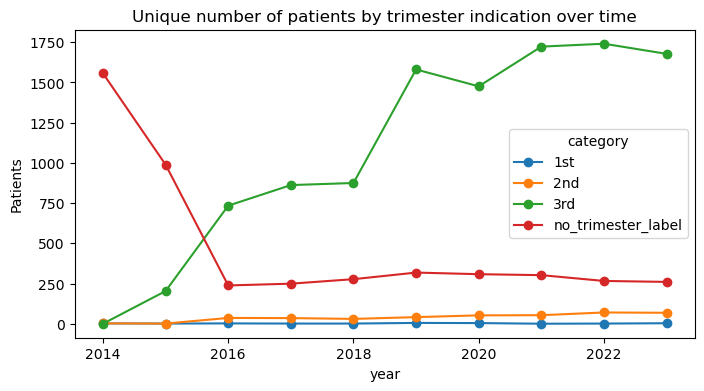

In [7]:
# 1. detect_trimester stays the same
def detect_trimester(text):
    if not isinstance(text, str):
        return np.nan
    t = text.lower()
    if re.search(r"\b1(?:st)?\s*(?:tri|trimester)\b", t):
        return "1st"
    if re.search(r"\b2(?:nd)?\s*(?:tri|trimester)\b", t):
        return "2nd"
    if re.search(r"\b3(?:rd)?\s*(?:tri|trimester)\b", t):
        return "3rd"
    return np.nan

df["tri_text"] = df["indications"].apply(detect_trimester)

# 2. collapse to one row per scan, gathering all tags
scan_tri = (
    df
      .groupby(["id","date_time"])["tri_text"]
      .agg(lambda tags: set(tags.dropna()))
      .reset_index(name="tri_tags")
)

# 3. categorize into exactly the three buckets (or "no_trimester_label")
def categorize(tags):
    if "1st" in tags:
        return "1st"
    elif "2nd" in tags:
        return "2nd"
    elif "3rd" in tags:
        return "3rd"
    else:
        return "no_trimester_label"

scan_tri["category"] = scan_tri["tri_tags"].apply(categorize)

# 4. now count scans in each category
scan_counts = scan_tri["category"].value_counts().sort_index()
print("Ultrasound Indications Counts by Trimester:\n", scan_counts)


# assuming `scan_tri` is your one‑row‐per‐scan DataFrame with columns
#    id, date_time, tri_tags, category

# Count unique patient IDs per category
patients_by_tri = (
    scan_tri
      .groupby("category")["id"]
      .nunique()
      .sort_index()
)
print("Distinct Patient Counts by Trimester:\n", patients_by_tri)

# 1) add a year column
scan_tri["year"] = scan_tri["date_time"].dt.year

# 2) build a table: years × categories → unique patients
trend = (
    scan_tri
      .groupby(["year","category"])["id"]
      .nunique()
      .unstack("category")
      .fillna(0)
      .sort_index(axis=1)    # alphabetical: 1st, 2nd, 3rd, no_trimester_label
)

print(trend)

# 3) plot it
trend.plot(marker="o", figsize=(8,4))
plt.title("Unique number of patients by trimester indication over time")
plt.ylabel("Patients")
plt.show()


## Indication Categorization 

In [8]:
import re

bucket_patterns = {
    ## maternal related
    "Bariatric Surgery": [
        "bariatric"
    ],
    
    "Obesity": [
        "obesity",
        "bmi"
    ],
    
    "Dating & Gestational Age Assessments": [
        "post dates",
        r"\bedd\b",
        r"\blmp\b",
        "dating scan",
        "weeks gestation",
        "gestational age",
        r"p[- ]?prom",
        "prom"
    ],
    
    "Other Maternal Health Conditions": [
        "asthma",
     #"Neurologic & Seizure Disorders": [
        # 神经系统或癫痫发作
        "seizure", "nervous system",
    #"Renal & Genitourinary Disorders": [
        # 肾/泌尿
        "kidney", "renal", "chronic kidney disease",
    #"Gynecologic Conditions": [
        # 卵巢、输卵管等妇科病
        "ovarian cyst", "leiomyomata", "fibroid",
    #"Gastrointestinal & Liver Disorders": [
        # 消化系统与肝胆
        "digestive system", "liver", "biliary",
        "hyperemesis"
         

    ],
    
    "Fetal Anomalies & Abnormal Screening Findings": [
        "anomal",
        "unusual finding",
        "abnormal ultrasound",
        "screening",
        "nipt",
        "complex cardiac defect",
        "screening",
        "vsd",
        "hlhs",
        "ventriculomegaly",
        "ntd",
        "trisomy 21",
        "pyelectasis",
        "dilated bowel",
        "ventriculomegaly",
        "svt",         
        r"\bfetal malformation\b",  
        "abnormality",
        "abnormalities","fetal anomalies",
        r"\butd\b"
        
    ],
    
    "Autoimmune & Genetic Risk Factors": [
        "autoimmune",
        "hereditary",
        "lupus erythematosus",
        "genetic",
        "factor v leiden",
        "chromosomal",
        "genetic",
        "chromosomal",
        r"\btrisomy\b",
        "congenital malformations"
    ],
    
    "Advanced Maternal Age": [
        r"\badvanced maternal age\b"
    ],
    
    "Bleeding, Pain & Hemorrhage": [
        "bleeding",
        "spotting",
        "pelvic pain",
        "pain in pregnancy"
    ],
    
       
    "Lifestyle & Substance & Medication": [
        "smoking",
        "smoker",
        "alcohol",
        "substance",
        "medication",
        "drug",
        "effexor",
        "medical procedure",
        "radiation"
    ],
    
    "Maternal Weight Gain Abnormalities": [
        "insufficient weight gain",
        "excessive weight gain",
        "insufficient weigt gain"
    ],
    
    "Mental Health Conditions": [
        r"\bmental\b",
        "depression",
        "anxiety",
        "bipolar",
        "psychiatric",
        "other mental disorders"
    ],
    
    "Trauma & External Injury": [
        "trauma",
        "injury due to external cause",
        "motor vehicle accident"
    ],
    
    "Fetal Demise / Stillbirth": [
        "fdiu",
        "death",
        "stillbirth",
        "continuing pregnancy after sab",
        "hydrops fetalis",
        "iufd"
    ],

    "Metabolic & Endocrine Disorders": [
        # 代谢或内分泌相关
        "diabetes", "glucose", "thyroid",
        "metabolic", "endocrine"
    ],

    "Hematologic & Anemia": [
        # 血液系统或贫血
        "anemia", "blood", "isoimmunization"
    ],

    "Cardiovascular Conditions": [
        # 心血管
        "hypertension", "pih", 
        "heart disease", "arrhythmia",
        r"preeclampsia", r"pre-eclampsia",
        "cardiovascular",
        "diseases of the circulatory system"
    ],
    
 
    
    "Growth & Size Discrepancies": [
        "size",
        "discrepanc",
        "iugr",
        "macrosom",
        "poor fetal growth",
        "excessive fetal growth",
        "intrauterine growth restriction",
        "fundal height",
        "growth"
    ],
    
    "Fetal Position": [
        "breech",
        "transverse",
        "presentation",
        "oblique",
        "unstable lie"
    ],
    
    "Obstetric History & Uterine/Cervical": [
        # 剖宫产、子宫/宫颈结构或经历
        #"multigravida", "primigravida",            # 多产、初产
        #"history of", # 产科既往史
        "pregnancy with history of",
        "recurrent pregnancy loss",
        "history of prior stillbirth",
        "history of stillbirth or neonatal death",
        "previous pregnancy",
        "previous c-section", "scar",
        r"cervix",
        "cervical",
        "myomas",                                  # 宫肌瘤
        "uterine leiomyomata",
        "preterm birth", "preterm labor", r"pre[- ]?term labor",      # 早产
        r"\b(?:uterine|cervical) malformation\b",            
        "habitual aborter",
        r"\buterine\b",
        "uterus"
    ],
    
    "Fetal Well‑Being Assessment": [
        r"non[- ]?reactive[- ]?nst",   
        r"non[- ]?stress",            
        r"\bnst\b",
        r"\bbpp\b",  
        "fetal movement",
        "fetal heart",
        "fetal lung maturity"
    ],
    
    "Amniotic Fluid Abnormalities": [
        "oligohydramnios",
        "polyhydramnios",
        r"\bafi\b",
        "amniotic",
        "afv",
        "amniotic fluid volume"
    ],
    
    "Placenta & Cord Conditions": [
        "placenta",
        "placental",
        "velamentous",
        "vasa previa",
        "cord",
        "single umbilical artery",
        "2vc"
    ],
    

    
    "Reproductive Technology & Multiples": [
        "assisted reproductive",
        r"\bivf\b",
        r"\biui\b",
        "twin",
        "fetal reduction"
    ],
    

    "Infection & Inflammation": [
        "chorioamnionitis",
        "infection",
        "gbs",
        "syphilis",
        "viral",
        "herpes",
        "hepatitis",
        "hiv"
    ],
    
    "Prenatal Care & Follow‑Up": [
        "prenatal",
        "follow-up",
        "routine anatomy",
        "repeat scan",
        "high risk pregnancy",
        "consult",
        "supervision of",
        "encounter for antenatal screening for"
        
    ],

    "Other Rare or Miscellaneous": []
}

df["indications"] = df["indications"].str.replace("\xa0", " ")
df["ind_bucket"] = "Other Rare or Miscellaneous"
for bucket, patterns in bucket_patterns.items():
    if not patterns:
        continue
    regex = "(" + "|".join(patterns) + ")"
    mask  = df["indications"].str.contains(regex, flags=re.IGNORECASE, na=False)
    df.loc[mask, "ind_bucket"] = bucket

print(df["ind_bucket"].value_counts(dropna=False))




/var/folders/nw/3jwfxsxs5hjf1kw6d5bq2bnw0000gn/T/ipykernel_69915/1801229602.py:270: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask  = df["indications"].str.contains(regex, flags=re.IGNORECASE, na=False)
/var/folders/nw/3jwfxsxs5hjf1kw6d5bq2bnw0000gn/T/ipykernel_69915/1801229602.py:270: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask  = df["indications"].str.contains(regex, flags=re.IGNORECASE, na=False)
/var/folders/nw/3jwfxsxs5hjf1kw6d5bq2bnw0000gn/T/ipykernel_69915/1801229602.py:270: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask  = df["indications"].str.contains(regex, flags=re.IGNORECASE, na=False)
/var/folders/nw/3jwfxsxs5hjf1kw6d5bq2bnw0000gn/T/ipykernel_69915/1801229602.py:270: UserWarning: This pattern is

ind_bucket
Obesity                                          15981
Dating & Gestational Age Assessments              5942
Growth & Size Discrepancies                       5912
Obstetric History & Uterine/Cervical              5678
Lifestyle & Substance & Medication                4390
Fetal Anomalies & Abnormal Screening Findings     3374
Advanced Maternal Age                             3248
Metabolic & Endocrine Disorders                   3176
Cardiovascular Conditions                         2867
Prenatal Care & Follow‑Up                         2472
Fetal Well‑Being Assessment                       2182
Amniotic Fluid Abnormalities                      1770
Reproductive Technology & Multiples               1532
Fetal Position                                    1425
Autoimmune & Genetic Risk Factors                 1393
Other Rare or Miscellaneous                        801
Other Maternal Health Conditions                   758
Placenta & Cord Conditions                         483

In [9]:
mapping = pd.read_excel(
    "2025_5_22_bucket_indications_updated.xlsx",
    usecols=["Indication","Bucket"],
    dtype=str
)

df = (
    df
    .merge(mapping,
           left_on="indications",
           right_on="Indication",
           how="left")
    .drop(columns="Indication")      # optional cleanup
)

# 3) if you really want to remove the old ind_bucket column
df = df.drop(columns=["ind_bucket"])

# now df2 has all your original columns plus the new 'Bucket' column

df = df.rename(columns={"Bucket": "ind_bucket"})

clean = (
    df["ind_bucket"]  # or df2["Bucket"] if you haven't renamed yet
      .str.replace("\u202f", " ", regex=False)   # narrow no‑break → normal space
      .str.replace("\xa0",  " ", regex=False)   # no‑break → normal space
      .str.replace("\u200b", "",  regex=False)  # drop zero‑width
      .str.strip()                              # trim leading/trailing
)

df["ind_bucket"] = clean

unique_buckets = df["ind_bucket"].unique()
print(unique_buckets)

['Fetal Position' 'Cardiovascular Conditions'
 'Lifestyle & Substance & Medication' 'Growth & Size Discrepancies'
 'Obstetric History & Uterine/Cervical' 'Fetal Well‑Being Assessment'
 'Amniotic Fluid Abnormalities' 'Dating & Gestational Age Assessments'
 'Bleeding, Pain & Hemorrhage' 'Obesity' 'Placenta & Cord Conditions'
 'Fetal Anomalies & Abnormal Screening Findings' nan
 'Reproductive Technology & Multiples' 'Other Maternal Health Conditions'
 'Metabolic & Endocrine Disorders' 'Prenatal Care & Follow‑Up'
 'Infection & Inflammation' 'Advanced Maternal Age'
 'Excessive Fetal Growth' 'Poor Fetal Growth'
 'Maternal Weight Gain - Insufficient' 'Autoimmune & Genetic Risk Factors'
 'Hematologic & Anemia' 'Mental Health Conditions'
 'Trauma & External Injury' 'Fetal Demise / Stillbirth'
 'Maternal Weight Gain - Excessive' 'Bariatric Surgery'
 'Other Rare or Miscellaneous']


In [10]:
print(df.shape)
df

(64967, 23)


,id,date_time,location,accession,indications,afi_sum,bpd,hc,ac,fl,...,ac_ptile,fl_ptile,hum_ptile,edd,f_weight,ptile,best,n_indications,tri_text,ind_bucket
0,002061,2014-07-28 09:35:00,Highland,NaN,breech presentation suspected,12.42,95.599998,351.899994,354.500000,70.800003,...,> 97,50,NaN,2014-08-04,3612.0,> 90,36w 1d,4,NaN,Fetal Position
1,002061,2014-07-28 09:35:00,Highland,NaN,"hypertension, chronic",12.42,95.599998,351.899994,354.500000,70.800003,...,> 97,50,NaN,2014-08-04,3612.0,> 90,36w 1d,4,NaN,Cardiovascular Conditions
2,002061,2014-07-28 09:35:00,Highland,NaN,medication use in pregnacy,12.42,95.599998,351.899994,354.500000,70.800003,...,> 97,50,NaN,2014-08-04,3612.0,> 90,36w 1d,4,NaN,Lifestyle & Substance & Medication
3,002061,2014-07-28 09:35:00,Highland,NaN,size greater than dates,12.42,95.599998,351.899994,354.500000,70.800003,...,> 97,50,NaN,2014-08-04,3612.0,> 90,36w 1d,4,NaN,Growth & Size Discrepancies
4,006520,2015-03-03 15:40:00,Highland,E124319797,"breech presentation suspected, not found",11.28,89.599998,325.899994,333.700012,69.599998,...,77,24,NaN,2015-03-27,3020.0,67,36w 5d,1,NaN,Fetal Position
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64962,E999356,2021-07-19 08:32:00,Highland POB,RIS4007446,"gestational diabetes, insulin controlled",13.56,84.500000,315.899994,318.500000,69.699997,...,50,36,NaN,2021-08-21,2706.0,50,36w 1d,5,NaN,Metabolic & Endocrine Disorders
64963,E999356,2021-07-19 08:32:00,Highland POB,RIS4007446,morbid obesity,13.56,84.500000,315.899994,318.500000,69.699997,...,50,36,NaN,2021-08-21,2706.0,50,36w 1d,5,NaN,Obesity
64964,E999356,2021-07-19 08:32:00,Highland POB,RIS4007446,"obesity complicating pregnancy, 3rd tri",13.56,84.500000,315.899994,318.500000,69.699997,...,50,36,NaN,2021-08-21,2706.0,50,36w 1d,5,3rd,Obesity
64965,E999356,2021-07-19 08:32:00,Highland POB,RIS4007446,adult bmi 45-49.9,13.56,84.500000,315.899994,318.500000,69.699997,...,50,36,NaN,2021-08-21,2706.0,50,36w 1d,5,NaN,Obesity


In [11]:
print(df["ind_bucket"].value_counts(dropna=False))

ind_bucket
Obesity                                          15981
Dating & Gestational Age Assessments              5946
Obstetric History & Uterine/Cervical              5735
Lifestyle & Substance & Medication                4398
Fetal Anomalies & Abnormal Screening Findings     3504
Advanced Maternal Age                             3248
Metabolic & Endocrine Disorders                   3178
Cardiovascular Conditions                         2875
Poor Fetal Growth                                 2697
Prenatal Care & Follow‑Up                         2568
Fetal Well‑Being Assessment                       2190
Excessive Fetal Growth                            1961
Amniotic Fluid Abnormalities                      1781
Reproductive Technology & Multiples               1546
Autoimmune & Genetic Risk Factors                 1451
Fetal Position                                    1425
Growth & Size Discrepancies                       1263
Other Maternal Health Conditions                   990

In [12]:
## Search the indications in bucket 
bucket_to_indications = (
    df.groupby("ind_bucket")["indications"]
      .apply(lambda x: sorted(set(x)))
      .to_dict()
)

obesity_inds = bucket_to_indications["Bariatric Surgery"]
for ind in obesity_inds:
    print(ind)

bariatric surgery status
bariatric surgery status (history of)
bariatric surgery status complicating pregnancy, 2nd tri
bariatric surgery status complicating pregnancy, 3rd tri


In [13]:
## save to excel file 
rows = []
for bucket, indications in bucket_to_indications.items():
    for ind in indications:
        rows.append({"Bucket": bucket, "Indication": ind})
df_export = pd.DataFrame(rows)

ind_counts = df["indications"].value_counts()
df_export["Count"] = df_export["Indication"].map(ind_counts).fillna(0).astype(int)

# 2. Write to Excel
#output_file = "bucket_indications_May_28.xlsx"
#df_export.to_excel(output_file, index=False)

## One hot Encoding 

In [14]:
dums = pd.get_dummies(df,
                      columns=['ind_bucket'],
                      prefix="",
                      prefix_sep="",
                      dtype=int)
dums

,id,date_time,location,accession,indications,afi_sum,bpd,hc,ac,fl,...,Metabolic & Endocrine Disorders,Obesity,Obstetric History & Uterine/Cervical,Other Maternal Health Conditions,Other Rare or Miscellaneous,Placenta & Cord Conditions,Poor Fetal Growth,Prenatal Care & Follow‑Up,Reproductive Technology & Multiples,Trauma & External Injury
0,002061,2014-07-28 09:35:00,Highland,NaN,breech presentation suspected,12.42,95.599998,351.899994,354.500000,70.800003,...,0,0,0,0,0,0,0,0,0,0
1,002061,2014-07-28 09:35:00,Highland,NaN,"hypertension, chronic",12.42,95.599998,351.899994,354.500000,70.800003,...,0,0,0,0,0,0,0,0,0,0
2,002061,2014-07-28 09:35:00,Highland,NaN,medication use in pregnacy,12.42,95.599998,351.899994,354.500000,70.800003,...,0,0,0,0,0,0,0,0,0,0
3,002061,2014-07-28 09:35:00,Highland,NaN,size greater than dates,12.42,95.599998,351.899994,354.500000,70.800003,...,0,0,0,0,0,0,0,0,0,0
4,006520,2015-03-03 15:40:00,Highland,E124319797,"breech presentation suspected, not found",11.28,89.599998,325.899994,333.700012,69.599998,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64962,E999356,2021-07-19 08:32:00,Highland POB,RIS4007446,"gestational diabetes, insulin controlled",13.56,84.500000,315.899994,318.500000,69.699997,...,1,0,0,0,0,0,0,0,0,0
64963,E999356,2021-07-19 08:32:00,Highland POB,RIS4007446,morbid obesity,13.56,84.500000,315.899994,318.500000,69.699997,...,0,1,0,0,0,0,0,0,0,0
64964,E999356,2021-07-19 08:32:00,Highland POB,RIS4007446,"obesity complicating pregnancy, 3rd tri",13.56,84.500000,315.899994,318.500000,69.699997,...,0,1,0,0,0,0,0,0,0,0
64965,E999356,2021-07-19 08:32:00,Highland POB,RIS4007446,adult bmi 45-49.9,13.56,84.500000,315.899994,318.500000,69.699997,...,0,1,0,0,0,0,0,0,0,0


In [15]:
record_cols = ["id", "date_time"]
dummy_cols = [
    'Advanced Maternal Age', 
    'Amniotic Fluid Abnormalities', 
    'Autoimmune & Genetic Risk Factors', 
    'Bariatric Surgery', 
    'Bleeding, Pain & Hemorrhage', 
    'Cardiovascular Conditions', 
    'Dating & Gestational Age Assessments', 
    'Excessive Fetal Growth', 
    'Fetal Anomalies & Abnormal Screening Findings', 
    'Fetal Demise / Stillbirth', 
    'Fetal Position', 
    'Fetal Well‑Being Assessment', 
    'Growth & Size Discrepancies', 
    'Hematologic & Anemia', 
    'Infection & Inflammation', 
    'Lifestyle & Substance & Medication', 
    'Maternal Weight Gain - Excessive', 
    'Maternal Weight Gain - Insufficient', 
    'Mental Health Conditions', 
    'Metabolic & Endocrine Disorders', 
    'Obesity', 
    'Obstetric History & Uterine/Cervical', 
    'Other Maternal Health Conditions', 
    'Other Rare or Miscellaneous', 
    'Placenta & Cord Conditions', 
    'Poor Fetal Growth', 
    'Prenatal Care & Follow‑Up', 
    'Reproductive Technology & Multiples', 
    'Trauma & External Injury'
]

other_cols = ['location', 
              'accession', 
              'afi_sum', 
              'bpd', 
              'hc', 
              'ac', 
              'fl', 
              'hum', 
              'bpd_ptile', 
              'hc_ptile', 
              'ac_ptile', 
              'fl_ptile', 
              'hum_ptile', 
              'edd', 
              'f_weight', 
              'ptile', 
              'best',
              'n_indications', 
              'tri_text']

agg_spec = {col: "first" for col in other_cols}
agg_spec.update({col: "max"   for col in dummy_cols})
agg_spec['indications'] = lambda x: "; ".join(x.dropna().astype(str).unique())


wide = (
    dums
    .groupby(record_cols, as_index=False)
    .agg(agg_spec)
)

# wide now has exactly one row per (id, date_time, accession)
# and columns for every bucket containing 0/1
print(wide.shape)

#wide.to_csv("indication_onerow_per_records.csv", index=False)

wide.head()

(19852, 51)


,id,date_time,location,accession,afi_sum,bpd,hc,ac,fl,hum,...,Obesity,Obstetric History & Uterine/Cervical,Other Maternal Health Conditions,Other Rare or Miscellaneous,Placenta & Cord Conditions,Poor Fetal Growth,Prenatal Care & Follow‑Up,Reproductive Technology & Multiples,Trauma & External Injury,indications
0,002061,2014-07-28 09:35:00,Highland,None,12.42,95.599998,351.899994,354.500000,70.800003,NaN,...,0,0,0,0,0,0,0,0,0,"breech presentation suspected; hypertension, c..."
1,006520,2015-03-03 15:40:00,Highland,E124319797,11.28,89.599998,325.899994,333.700012,69.599998,NaN,...,0,0,0,0,0,0,0,0,0,"breech presentation suspected, not found"
2,008177,2014-01-31 11:13:00,Highland,None,15.53,86.000000,313.600006,314.600006,68.000000,NaN,...,0,1,0,0,0,0,0,0,0,bicornuate uterus; size greater than dates
3,011562,2014-11-14 13:14:00,Highland,E1276191,8.36,88.300003,321.600006,335.700012,68.699997,NaN,...,0,0,0,0,0,0,0,0,0,decreased fetal movement
4,011842,2014-04-09 08:23:00,Highland,None,9.70,88.300003,322.200012,308.299988,67.199997,NaN,...,0,0,0,0,0,0,0,0,0,size less than dates


In [16]:
wide_last = (
    wide
    .sort_values(["id", "date_time"])      # newest last
    .drop_duplicates(subset="id", keep="last")
    .reset_index(drop=True)
)
wide_last

#wide_last.to_csv("indication_onerow_per_patients_last.csv", index=False)

,id,date_time,location,accession,afi_sum,bpd,hc,ac,fl,hum,...,Obesity,Obstetric History & Uterine/Cervical,Other Maternal Health Conditions,Other Rare or Miscellaneous,Placenta & Cord Conditions,Poor Fetal Growth,Prenatal Care & Follow‑Up,Reproductive Technology & Multiples,Trauma & External Injury,indications
0,002061,2014-07-28 09:35:00,Highland,None,12.42,95.599998,351.899994,354.500000,70.800003,NaN,...,0,0,0,0,0,0,0,0,0,"breech presentation suspected; hypertension, c..."
1,006520,2015-03-03 15:40:00,Highland,E124319797,11.28,89.599998,325.899994,333.700012,69.599998,NaN,...,0,0,0,0,0,0,0,0,0,"breech presentation suspected, not found"
2,008177,2014-01-31 11:13:00,Highland,None,15.53,86.000000,313.600006,314.600006,68.000000,NaN,...,0,1,0,0,0,0,0,0,0,bicornuate uterus; size greater than dates
3,011562,2014-11-14 13:14:00,Highland,E1276191,8.36,88.300003,321.600006,335.700012,68.699997,NaN,...,0,0,0,0,0,0,0,0,0,decreased fetal movement
4,011842,2014-05-08 10:49:00,Highland,None,1.20,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,oligohydramnios
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13732,E998443,2019-02-26 15:38:00,Red Creek,E292750748,10.77,91.199997,320.100006,331.100006,70.099998,NaN,...,0,0,1,0,0,0,0,0,0,"pregnancy related condition, unspecified, 3rd tri"
13733,E998632,2018-12-03 14:13:00,Lattimore,E289590369,10.59,86.300003,309.799988,322.700012,66.900002,NaN,...,1,0,0,0,0,0,0,0,0,"advanced maternal age, multigravida, 2nd tri; ..."
13734,E999212,2023-11-21 15:31:00,Highland POB,RIS16186883,21.85,89.699997,334.500000,347.100006,68.400002,58.500000,...,1,1,0,0,0,0,0,0,0,"advanced maternal age, multigravida, 3rd tri; ..."
13735,E999284,2023-04-05 09:45:00,Highland POB,RIS12107789,24.50,90.400002,332.700012,364.399994,69.699997,60.799999,...,1,0,0,0,0,0,0,0,0,medication use in pregnancy (single pregnancy)...


In [17]:
indications = pd.read_csv ("indication_onerow_per_patients_last.csv")
indications["date_time"] = pd.to_datetime(indications["date_time"], errors="coerce")
print(indications.shape)
indications

(13737, 51)


,id,date_time,location,accession,afi_sum,bpd,hc,ac,fl,hum,...,Obesity,Obstetric History & Uterine/Cervical,Other Maternal Health Conditions,Other Rare or Miscellaneous,Placenta & Cord Conditions,Poor Fetal Growth,Prenatal Care & Follow‑Up,Reproductive Technology & Multiples,Trauma & External Injury,indications
0,002061,2014-07-28 09:35:00,Highland,NaN,12.42,95.599998,351.899994,354.500000,70.800003,NaN,...,0,0,0,0,0,0,0,0,0,"breech presentation suspected; hypertension, c..."
1,006520,2015-03-03 15:40:00,Highland,E124319797,11.28,89.599998,325.899994,333.700012,69.599998,NaN,...,0,0,0,0,0,0,0,0,0,"breech presentation suspected, not found"
2,008177,2014-01-31 11:13:00,Highland,NaN,15.53,86.000000,313.600006,314.600006,68.000000,NaN,...,0,1,0,0,0,0,0,0,0,bicornuate uterus; size greater than dates
3,011562,2014-11-14 13:14:00,Highland,E1276191,8.36,88.300003,321.600006,335.700012,68.699997,NaN,...,0,0,0,0,0,0,0,0,0,decreased fetal movement
4,011842,2014-05-08 10:49:00,Highland,NaN,1.20,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,oligohydramnios
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13732,E998443,2019-02-26 15:38:00,Red Creek,E292750748,10.77,91.199997,320.100006,331.100006,70.099998,NaN,...,0,0,1,0,0,0,0,0,0,"pregnancy related condition, unspecified, 3rd tri"
13733,E998632,2018-12-03 14:13:00,Lattimore,E289590369,10.59,86.300003,309.799988,322.700012,66.900002,NaN,...,1,0,0,0,0,0,0,0,0,"advanced maternal age, multigravida, 2nd tri; ..."
13734,E999212,2023-11-21 15:31:00,Highland POB,RIS16186883,21.85,89.699997,334.500000,347.100006,68.400002,58.500000,...,1,1,0,0,0,0,0,0,0,"advanced maternal age, multigravida, 3rd tri; ..."
13735,E999284,2023-04-05 09:45:00,Highland POB,RIS12107789,24.50,90.400002,332.700012,364.399994,69.699997,60.799999,...,1,0,0,0,0,0,0,0,0,medication use in pregnancy (single pregnancy)...


In [18]:
bc_highland = pd.read_csv("Birth_Certificate_Highland.csv")
bc_strong = pd.read_csv("Birth_Certificate_Strong.csv")
bc_combined = pd.concat([bc_strong, bc_highland], ignore_index=True)
bc_combined

/var/folders/nw/3jwfxsxs5hjf1kw6d5bq2bnw0000gn/T/ipykernel_69915/1241775796.py:1: DtypeWarning: Columns (133) have mixed types. Specify dtype option on import or set low_memory=False.
  bc_highland = pd.read_csv("Birth_Certificate_Highland.csv")
/var/folders/nw/3jwfxsxs5hjf1kw6d5bq2bnw0000gn/T/ipykernel_69915/1241775796.py:2: DtypeWarning: Columns (133) have mixed types. Specify dtype option on import or set low_memory=False.
  bc_strong = pd.read_csv("Birth_Certificate_Strong.csv")


,MRN,Date___Time,hospcode,reszip5,sex_of_inf,plurality,birth_orde,birth_wgt,mom_medrec,mom_whi,...,num_exer_q,depression,mom_hospitalized,mom_adm,mom_dischg,status_inf,yeardob,lmp_date,inf_medrec,infant_month
0,1335208,1/6/14,Strong,14616.0,2:Female,1:Single,single,2515,1335208,0:No,...,0.0,2:A little depressed,10.0,1052014.0,1122014.0,5:Transferred out,2014,19MAY****,2958754,1
1,1349305,1/13/14,Strong,14616.0,1:Male,1:Single,single,3820,1349305,1:Yes,...,NaN,missing,0.0,1132014.0,1162014.0,3:Still in hospital,2014,31AUG****,2959912,1
2,2574056,1/6/14,Strong,14624.0,2:Female,1:Single,single,3816,2574056,1:Yes,...,0.0,2:A little depressed,0.0,1192014.0,1232014.0,1:Discharged home,2014,23SEP****,2961124,1
3,2574056,1/10/14,Strong,14624.0,2:Female,1:Single,single,3816,2574056,1:Yes,...,0.0,2:A little depressed,0.0,1192014.0,1232014.0,1:Discharged home,2014,23SEP****,2961124,1
4,2785918,1/17/14,Strong,14618.0,2:Female,1:Single,single,2920,2785918,1:Yes,...,1.0,1:Not depressed at all,0.0,1202014.0,1212014.0,1:Discharged home,2014,21DEC****,2961185,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31554,E1939278,9/13/22,Highland,14619.0,2:Female,1:Single,single,3130,E1939278,1:Yes,...,1.0,1:Not depressed at all,0.0,9292022.0,10012022.0,1:Discharged home,2022,30DEC2021,E3583987,9
31555,E1939278,9/13/22,Highland,14619.0,2:Female,1:Single,single,3130,E1939278,1:Yes,...,1.0,1:Not depressed at all,0.0,9292022.0,10012022.0,1:Discharged home,2022,30DEC2021,E3583987,9
31556,E1939278,9/13/22,Highland,14619.0,2:Female,1:Single,single,3130,E1939278,1:Yes,...,1.0,1:Not depressed at all,0.0,9292022.0,10012022.0,1:Discharged home,2022,30DEC2021,E3583987,9
31557,E1939278,9/13/22,Highland,14619.0,2:Female,1:Single,single,3130,E1939278,1:Yes,...,1.0,1:Not depressed at all,0.0,9292022.0,10012022.0,1:Discharged home,2022,30DEC2021,E3583987,9


In [19]:
pd.set_option("display.max_rows", 200)
print(bc_combined.dtypes)

MRN                  object
Date___Time          object
hospcode             object
reszip5             float64
sex_of_inf           object
plurality            object
birth_orde           object
birth_wgt             int64
mom_medrec           object
mom_whi              object
mom_bla              object
mom_si               object
mom_chi              object
mom_fil              object
mom_jap              object
mom_kor              object
mom_vie              object
mom_nha              object
mom_gua              object
mom_sam              object
mom_aina             object
mom_oas              object
mom_opi              object
mom_oth              object
mhis_no              object
mhis_me              object
mhis_pr              object
mhis_cu              object
mhis_ot              object
mom_educ             object
mom_occup            object
mom_employ           object
first_visit_date    float64
last_visit_date     float64
num_visits          float64
est_gest            

In [20]:
cols_to_int = [
    "birth_wgt",
    "est_gest",
    "live_livex",
    "tot_preg",
    "mu_lb",
    "apgar_1_mi",
    "apgar_5_mi",
    "apgar_10_mi",
    "num_cs",
    "infant_month"
    
]
for col in cols_to_int:
    bc_combined[col] = bc_combined[col].astype("Int64")
    
# Suppose `merged_exact` is your merged DataFrame
bc_combined["primary_pr"] = bc_combined["primary_pr"].astype(str)

In [21]:
#Date___Time: object
bc_combined['Date___Time'] = pd.to_datetime(bc_combined['Date___Time'], errors='coerce')
print(bc_combined['Date___Time'].dtype)               # Should show datetime64[ns]
print(bc_combined['Date___Time'].head())              # Preview
print(bc_combined['Date___Time'].isna().sum())        # Count of invalid/missing

/var/folders/nw/3jwfxsxs5hjf1kw6d5bq2bnw0000gn/T/ipykernel_69915/3759023043.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  bc_combined['Date___Time'] = pd.to_datetime(bc_combined['Date___Time'], errors='coerce')


datetime64[ns]
0   2014-01-06
1   2014-01-13
2   2014-01-06
3   2014-01-10
4   2014-01-17
Name: Date___Time, dtype: datetime64[ns]
0


In [22]:
#first_visit_date: float64
#last_visit_date: float64
# Ensure strings and pad left with zeros so every entry is 8 digits
bc_combined['first_visit_date'] = bc_combined['first_visit_date'].fillna(0).astype(int)
bc_combined['last_visit_date'] = bc_combined['last_visit_date'].fillna(0).astype(int)

bc_combined['first_visit_date'] = bc_combined['first_visit_date'].astype(str)
bc_combined['last_visit_date'] = bc_combined['last_visit_date'].astype(str)

bc_combined['first_visit_date'] = bc_combined['first_visit_date'].str.zfill(8)
bc_combined['last_visit_date'] = bc_combined['last_visit_date'].str.zfill(8)

print(bc_combined['first_visit_date'].head(10))
print(bc_combined['last_visit_date'].head(10))

# Convert to datetime using the correct format
bc_combined['first_visit_date'] = pd.to_datetime(bc_combined['first_visit_date'], format='%m%d%Y', errors='coerce')
bc_combined['last_visit_date'] = pd.to_datetime(bc_combined['last_visit_date'], format='%m%d%Y', errors='coerce')

print(bc_combined['first_visit_date'].dtype)               # Should show datetime64[ns]
print(bc_combined['first_visit_date'].head())              # Preview
print(bc_combined['first_visit_date'].isna().sum())        # Count of invalid/missing

print(bc_combined['last_visit_date'].dtype)               # Should show datetime64[ns]
print(bc_combined['last_visit_date'].head())              # Preview
print(bc_combined['last_visit_date'].isna().sum())        # Count of invalid/missing


0    05222013
1    07032013
2    06112013
3    06112013
4    06062013
5    07032013
6    07032013
7    07032013
8    00000000
9    00000000
Name: first_visit_date, dtype: object
0    12192013
1    01132014
2    12262013
3    12262013
4    12182013
5    01222014
6    01222014
7    01222014
8    00000000
9    00000000
Name: last_visit_date, dtype: object
datetime64[ns]
0   2013-05-22
1   2013-07-03
2   2013-06-11
3   2013-06-11
4   2013-06-06
Name: first_visit_date, dtype: datetime64[ns]
1316
datetime64[ns]
0   2013-12-19
1   2014-01-13
2   2013-12-26
3   2013-12-26
4   2013-12-18
Name: last_visit_date, dtype: datetime64[ns]
739


In [23]:
# 1) If you want to drop rows that are exact duplicates across *all* columns:
bc_combined_cleaned = bc_combined.drop_duplicates(keep="first").copy()

# 2) (Optional) See how many rows you removed:
print("Original shape:", bc_combined.shape)
print("After dropping exact duplicates:", bc_combined_cleaned.shape)
print(bc_combined_cleaned["MRN"].nunique())

bc_twins = bc_combined_cleaned[bc_combined_cleaned["plurality"] == "2:Twin"].copy()

# 2) Inspect how many twin rows you have and view a few
print(f"Number of twin‐birth rows: {len(bc_twins)}")
bc_twins.head(10)

Original shape: (31559, 158)
After dropping exact duplicates: (8576, 158)
6087
Number of twin‐birth rows: 322


,MRN,Date___Time,hospcode,reszip5,sex_of_inf,plurality,birth_orde,birth_wgt,mom_medrec,mom_whi,...,num_exer_q,depression,mom_hospitalized,mom_adm,mom_dischg,status_inf,yeardob,lmp_date,inf_medrec,infant_month
17,1347134,2014-02-14,Strong,14487.0,1:Male,2:Twin,1st multiple birth,2840,1347134,1:Yes,...,0.0,1:Not depressed at all,0.0,2202014.0,2242014.0,1:Discharged home,2014,05JUN****,2967899,2
18,1347134,2014-02-14,Strong,14487.0,2:Female,2:Twin,2nd multiple birth,2735,1347134,1:Yes,...,0.0,1:Not depressed at all,0.0,2202014.0,2242014.0,1:Discharged home,2014,05JUN****,2967903,2
52,1143108,2014-05-27,Strong,14619.0,1:Male,2:Twin,1st multiple birth,2155,1143108,0:No,...,4.0,2:A little depressed,0.0,5282014.0,5292014.0,1:Discharged home,2014,*********,2987255,5
53,1143108,2014-05-27,Strong,14619.0,1:Male,2:Twin,2nd multiple birth,2316,1143108,0:No,...,4.0,2:A little depressed,0.0,5282014.0,5292014.0,1:Discharged home,2014,*********,2987256,5
82,1203599,2014-07-23,Strong,14613.0,1:Male,2:Twin,1st multiple birth,2675,1203599,0:No,...,3.0,1:Not depressed at all,0.0,7242014.0,7292014.0,1:Discharged home,2014,*********,3000061,7
83,1203599,2014-07-23,Strong,14613.0,2:Female,2:Twin,2nd multiple birth,2855,1203599,0:No,...,3.0,1:Not depressed at all,0.0,7242014.0,7292014.0,1:Discharged home,2014,*********,3000062,7
259,1242458,2016-02-02,Strong,14435.0,1:Male,2:Twin,1st multiple birth,2970,1242458,1:Yes,...,0.0,1:Not depressed at all,0.0,2102016.0,2152016.0,5:Transferred out,2016,12OCT****,3126945,2
260,1242458,2016-02-02,Strong,14435.0,1:Male,2:Twin,2nd multiple birth,2656,1242458,1:Yes,...,0.0,1:Not depressed at all,0.0,2102016.0,2152016.0,1:Discharged home,2016,12OCT****,3126946,2
273,1020884,2016-03-15,Strong,14467.0,2:Female,2:Twin,1st multiple birth,2809,1020884,1:Yes,...,3.0,1:Not depressed at all,0.0,3232016.0,3262016.0,1:Discharged home,2016,*********,3140194,3
274,1020884,2016-03-15,Strong,14467.0,2:Female,2:Twin,2nd multiple birth,3036,1020884,1:Yes,...,3.0,1:Not depressed at all,0.0,3232016.0,3262016.0,1:Discharged home,2016,*********,3140196,3


In [36]:
bc_combined_cleaned["Date___Time"] = bc_combined_cleaned["Date___Time"].dt.normalize()
indications["date_time"]   = indications["date_time"].dt.normalize()

merged_exact = bc_combined_cleaned.merge(
    indications,
    left_on=["MRN",       "Date___Time"],
    right_on=["id",       "date_time"],
    how="inner"
)
merged_exact.sort_values(by="MRN", inplace=True)
print(merged_exact.shape)
#merged_exact.to_csv("merged_exact.csv", index=False)

(6060, 209)


In [25]:
print(merged_exact["MRN"].nunique())
merge_twins = merged_exact[merged_exact["plurality"] == "2:Twin"].copy()
print(merge_twins["MRN"].nunique())
merge_twins

5940
122


,MRN,Date___Time,hospcode,reszip5,sex_of_inf,plurality,birth_orde,birth_wgt,mom_medrec,mom_whi,...,Obesity,Obstetric History & Uterine/Cervical,Other Maternal Health Conditions,Other Rare or Miscellaneous,Placenta & Cord Conditions,Poor Fetal Growth,Prenatal Care & Follow‑Up,Reproductive Technology & Multiples,Trauma & External Injury,indications
193,1020884,2016-03-15,Strong,14467.0,2:Female,2:Twin,1st multiple birth,2809,1020884,1:Yes,...,0,0,0,0,0,0,0,1,0,"37 weeks gestation; advanced maternal age, mul..."
194,1020884,2016-03-15,Strong,14467.0,2:Female,2:Twin,2nd multiple birth,3036,1020884,1:Yes,...,0,0,0,0,0,0,0,1,0,"37 weeks gestation; advanced maternal age, mul..."
37,1143108,2014-05-27,Strong,14619.0,1:Male,2:Twin,2nd multiple birth,2316,1143108,0:No,...,0,0,0,0,0,1,0,1,0,"twins; twin gestation, dichorionic/diamniotic;..."
36,1143108,2014-05-27,Strong,14619.0,1:Male,2:Twin,1st multiple birth,2155,1143108,0:No,...,0,0,0,0,0,1,0,1,0,"twins; twin gestation, dichorionic/diamniotic;..."
62,1203599,2014-07-23,Strong,14613.0,2:Female,2:Twin,2nd multiple birth,2855,1203599,0:No,...,0,0,1,0,0,0,0,1,0,"twin gestation, dichorionic/diamniotic; pre-ec..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
483,E863922,2018-10-09,Strong,14621.0,2:Female,2:Twin,2nd multiple birth,3320,E863922,0:No,...,1,0,0,0,0,0,0,1,0,"adult bmi 45-49.9; twin gestation, dichorionic..."
5559,E921229,2022-04-06,Highland,14564.0,1:Male,2:Twin,2nd multiple birth,2801,E921229,1:Yes,...,0,0,0,0,0,0,0,1,0,"twin gestation, dichorionic/diamniotic, 3rd tri"
5558,E921229,2022-04-06,Highland,14564.0,2:Female,2:Twin,1st multiple birth,2884,E921229,1:Yes,...,0,0,0,0,0,0,0,1,0,"twin gestation, dichorionic/diamniotic, 3rd tri"
1139,E981182,2019-06-05,Strong,14533.0,2:Female,2:Twin,1st multiple birth,2886,E981182,1:Yes,...,1,1,0,0,0,0,0,1,0,adult bmi 30.0-30.9; obesity complicating preg...


In [31]:
print(merge_twins["MRN"].nunique())
print(merge_twins.shape)

122
(242, 209)


In [32]:
## Mom has twins but only has one baby birth certificates 
twin_counts = (
    merge_twins
    .groupby("MRN")
    .size()
    .reset_index(name="row_count")
)

# 3) Find which MRNs have fewer than 2 rows (i.e. exactly 1):
incomplete_twins = twin_counts[twin_counts["row_count"] < 2].copy()

print("MRNs that only have 1 twin‐row instead of 2:")
print(incomplete_twins)

MRNs that only have 1 twin‐row instead of 2:
         MRN  row_count
85  E3436052          1
98   E475177          1


In [35]:
merge_single = merged_exact[merged_exact["plurality"] == "1:Single"].copy()
print(merge_single["MRN"].nunique())
merge_single.shape

5818


(5818, 209)

In [33]:
merged_exact

,MRN,Date___Time,hospcode,reszip5,sex_of_inf,plurality,birth_orde,birth_wgt,mom_medrec,mom_whi,...,Obesity,Obstetric History & Uterine/Cervical,Other Maternal Health Conditions,Other Rare or Miscellaneous,Placenta & Cord Conditions,Poor Fetal Growth,Prenatal Care & Follow‑Up,Reproductive Technology & Multiples,Trauma & External Injury,indications
5284,006520,2015-03-03,Highland,14607.0,1:Male,1:Single,single,3754,006520,1:Yes,...,0,0,0,0,0,0,0,0,0,"breech presentation suspected, not found"
5255,008177,2014-01-31,Highland,14620.0,2:Female,1:Single,single,3419,008177,1:Yes,...,0,1,0,0,0,0,0,0,0,bicornuate uterus; size greater than dates
5258,018533,2014-06-03,Highland,14618.0,1:Male,1:Single,single,3538,018533,1:Yes,...,0,0,0,0,0,0,0,0,0,bleeding before 22 weeks; size greater than dates
5280,020567,2015-02-26,Highland,14586.0,2:Female,1:Single,single,2929,020567,1:Yes,...,0,0,0,0,0,0,0,0,0,size less than dates
5290,023246,2015-04-15,Highland,14624.0,1:Male,1:Single,single,4250,023246,0:No,...,0,0,0,0,1,0,0,0,0,post dates; 2 vessel umbilical cord; choroid p...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4793,E996890,2023-05-19,Strong,14623.0,2:Female,1:Single,single,3110,E996890,0:No,...,0,0,0,0,0,0,0,0,0,"hypertension, chronic, 3rd tri"
3056,E996991,2021-11-03,Strong,14534.0,2:Female,1:Single,single,3240,E996991,1:Yes,...,0,0,0,0,0,0,0,0,0,"advanced maternal age, multigravida, 3rd tri; ..."
1987,E998249,2020-04-22,Strong,14428.0,2:Female,1:Single,single,3960,E998249,1:Yes,...,1,0,0,0,0,0,0,0,0,"adult bmi 38.0-38.9; gestational diabetes, uns..."
905,E998443,2019-02-26,Strong,14522.0,2:Female,1:Single,single,3060,E998443,1:Yes,...,0,0,1,0,0,0,0,0,0,"pregnancy related condition, unspecified, 3rd tri"


In [38]:
(merged_exact["mu_lb"] == 1).sum()

1

In [41]:
m=merged_exact[merged_exact["MRN"]=="E475177"]
m["mu_lb"]

3589    2
Name: mu_lb, dtype: Int64